# **Importing modules**

In [1]:
import attr
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from datetime import datetime
from IPython.display import clear_output
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.applications import resnet
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Layer, Dense, Conv2D, MaxPool2D, Flatten, Concatenate, Add, Average, BatchNormalization, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.python.ops.gen_string_ops import string_split
from tqdm import tqdm

# **Connecting Drive**

In [2]:
PATH = "/Users/giamm/Downloads/content/drive/MyDrive/ProjectLandmarksRecognition"
if not os.path.exists(PATH):
    os.makedirs(PATH)

In [3]:
tf.keras.backend.manual_variable_initialization(True)

# **Data Loading**

Download train set and prepare to be feed

In [4]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

Download set

In [5]:
download_dir = PATH + "/download"
extract_dir = PATH + "/images"

images_download = [download_dir + "/" + dir for dir in os.listdir(download_dir)]

# Training set
train_clean_cvs = download_dir + "/train/train_clean.csv"
images_download = extract_dir + "/train/"

# Index set
index_cvs = download_dir + "/index/index_image_to_landmark.csv"
index_images = extract_dir + "/index/"

#Test set
test_cvs = download_dir + "/test/recognition_solution_v2.1.csv"
test_images = extract_dir + "/test/"

Function to read and resize image to feed to neaural network

In [6]:
def read_image(path, label, size):
    if not(tf.io.gfile.exists(path)):
        return None
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.float32)
    image = tf.image.resize(image, size)
    return image, label

Training set

In [7]:
df = pd.read_csv(train_clean_cvs)
stat_path = images_download
datas = []
labels = []

for (images_path, label) in zip(df["images"].values, df["landmark_id"].values):
    image_path = images_path.split()
    for img in image_path:
        p = stat_path + img[0] + "/" + img[1] + "/" + img[2] + "/" + img + ".jpg"
        if tf.io.gfile.exists(p):
          datas.append(p)
          labels.append(label)

datas = np.array(datas)
labels = np.array(labels)

Test set

In [8]:
df = pd.read_csv(test_cvs)
stat_path = test_images
test_paths = []
test_labels = []

for (images_path, label) in zip(df["id"].values, df["landmarks"].values):
    image_path = images_path.split()
    for img in image_path:
        p = stat_path + img[0] + "/" + img[1] + "/" + img[2] + "/" + img + ".jpg"
        if tf.io.gfile.exists(p):
          test_paths.append(p)
          test_labels.append(label)

test_paths = np.array(test_paths)
test_labels = np.array(test_labels)

Function to do data augmentation

In [9]:
def augment(image):
  if tf.random.uniform((), minval=0, maxval=1) < 0.25:
    image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])

  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.4, upper=1)

  image = tf.image.random_flip_left_right(image)
  
  image = tf.image.resize(tf.image.central_crop(image, tf.random.uniform((), minval=0.7, maxval=1)), image.shape[:2])

  return image

Generates labels for siamese network couples

In [10]:
def generate_arrays(labels):
  anchor_labels = []
  tmp = labels.copy()

  for lab in labels:
    if np.count_nonzero(tmp == lab) > 1:
      anchor_labels.append(lab)
      tmp = np.delete(tmp, np.where(tmp == lab))

  return np.array(anchor_labels)

In [11]:
a_labels = generate_arrays(labels)
dataset_labels = tf.data.Dataset.from_tensor_slices(a_labels)
dataset_labels = dataset_labels.shuffle(buffer_size=len(dataset_labels), seed=3, reshuffle_each_iteration=True)
train_labels = list(dataset_labels.take(round(a_labels.shape[0] * 0.8)).as_numpy_iterator())
validation_labels = list(dataset_labels.skip(round(a_labels.shape[0] * 0.8)).as_numpy_iterator())

# **Non-Landmark detection Model**

## Dataset generation

Landmarks presence or absence labels

In [12]:
landmark_labels = np.isin(labels, a_labels)

In [13]:
# Creating balanced 0-type and 1-type elements
temp_dataset = datas[landmark_labels]
temp_labels = landmark_labels[landmark_labels]
indexes_falses = np.random.choice(np.where(np.repeat(landmark_labels, 3) == False)[0], len(temp_dataset), False)
temp_dataset = np.append(temp_dataset, np.repeat(datas, 3)[indexes_falses])
temp_labels = np.append(temp_labels, np.repeat(landmark_labels, 3)[indexes_falses])

temp_dataset, temp_labels = shuffle(temp_dataset, temp_labels)
index_margin = round(temp_dataset.shape[0] * 0.8)
landmark_train_dataset, landmark_train_labels = temp_dataset[:index_margin], temp_labels[:index_margin]
landmark_validation_dataset, landmark_validation_labels = temp_dataset[index_margin:], temp_labels[index_margin:]

Generator for Non-Landmark Dataset

In [14]:
@attr.s(auto_attribs=True)
class NonLandmarkDatasetGenerator:
    """
    Args:
     dataset: paths of dataset's images
     labels: labels of dataset's elements
     batch_size: size of generated batches
     size: size of generated images
     shuffle: whether to shuffle the questions around
     augment_data: enable or not data augmentation
    """
    dataset: np.ndarray
    labels: np.ndarray
    batch_size: int
    size: tuple=(128, 128)
    shuffle: bool=True
    augment_data: bool=False
    _batch: iter=None

    def data_generator(self):
        num_samples = len(self.labels)
        
        while True:
            self.dataset, self.labels = shuffle(self.dataset, self.labels)

            # Iteration for each batch
            for offset in range(0, num_samples, self.batch_size):
                batch_images = self.dataset[offset:offset+self.batch_size]
                batch_labels = self.labels[offset:offset+self.batch_size]

                # Generated batch's data structures
                X_train = []
                y_train = []

                # Generating each element
                for path, label in zip(batch_images, batch_labels):
                    img = tf.io.read_file(path)
                    img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
                    img = tf.image.resize(img, IMAGE_SIZE)
                    if self.augment_data:
                      img = augment(img)

                    X_train.append(img)
                    y_train.append(label)
                    
                
                yield np.array(X_train), np.array(y_train)
                
                X_train, y_train = [], []

        return

    @property
    def batch(self):
        """The generator instance"""
        if self._batch is None:
            self._batch = self.data_generator()
        return self._batch

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.batch)

Non-Landmark data example

In [15]:
b_size = 4
g = NonLandmarkDatasetGenerator(dataset=landmark_train_dataset, labels=landmark_train_labels, batch_size=b_size, shuffle=True, augment_data=False)

In [16]:
t = next(g)

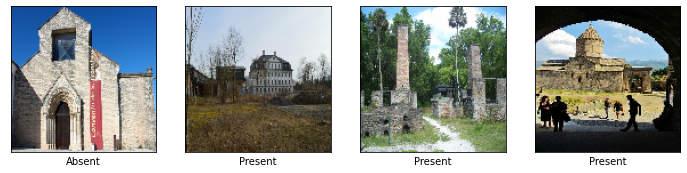

In [17]:
columns = 4
rows = 1
fig = plt.figure(figsize=(12, 6))
for i in np.arange(b_size):
  out = t[0][i]
  fig = plt.subplot(rows, columns, i + 1)
  fig.set_xticks([])
  fig.set_yticks([])
  des = "Present" if t[1][i] else "Absent"
  plt.xlabel(des)
  plt.imshow(out)
plt.show()

## Neural Network model

Function for building the Neural Network

In [31]:
def create_non_landmark_model(input_shape, loss_fn, accuracy, optimizer, block_base=False):
  # Creating embedding model - ResNet50
  input = Input(shape=input_shape)
  base_resnet = resnet.ResNet50(input_shape=input_shape, include_top=False, pooling='max')
  # Enabling  base model's parameters training
  if block_base:
    base_resnet.trainable = False
  else:
    trainable = False
    for layer in base_resnet.layers:
      if layer.name == "conv3_block4_out":
        trainable = True
      layer.trainable = trainable
  # Creating Neural Network
  base_resnet = base_resnet(input)
  output = Dense(1, activation="sigmoid")(base_resnet)
  model = Model(inputs=input, outputs=output, name="NonLandmarkModel")
  model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy])

  return model

In [32]:
non_landmark_model = create_non_landmark_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                               loss_fn=tf.keras.losses.BinaryCrossentropy(),
                                               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                                               accuracy=tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                                               block_base=False)

In [33]:
non_landmark_model.summary()

Model: "NonLandmarkModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 22,086,657
Non-trainable params: 1,503,104
_________________________________________________________________


### Training

In [ ]:
now = datetime.now().strftime("%Y_%m_%d_t_%H_%M")
check_point_path = "{}/checkpoints/Non_Landmark_Model_ResNet50_opt_Adam_s_{}_b{}_{}.h5".format(PATH, IMAGE_SIZE[0], BATCH_SIZE, now)
logs_path = "{}/logs/Non_Landmark_Model_ResNet50_opt_Adam_s_{}_b{}_{}.h5".format(PATH, IMAGE_SIZE[0], BATCH_SIZE, now)

Defining space where to save trained model checkpoint

In [ ]:
check_point = tf.keras.callbacks.ModelCheckpoint(filepath=check_point_path,
                                                 save_weights_only=False,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True)

Defining path to save model training parameters

In [ ]:
tb = TensorBoard(log_dir=logs_path)

In [ ]:
non_landmark_model.fit(NonLandmarkDatasetGenerator(dataset=landmark_train_dataset, labels=landmark_train_labels, batch_size=BATCH_SIZE, shuffle=True, data_augmentation=True), 
                       steps_per_epoch=len(landmark_train_dataset)//BATCH_SIZE,
                       validation_data=NonLandmarkDatasetGenerator(dataset=landmark_validation_dataset, labels=landmark_validation_labels, batch_size=BATCH_SIZE, shuffle=False), 
                       validation_steps=len(landmark_validation_dataset)//BATCH_SIZE,
                       epochs=250,
                       callbacks=[tb, check_point])

### Test

In [ ]:
non_landmark_threshold = 0.5
non_landmark_labels = np.array([])
non_landmark_truth = np.array([])
n_elements = 0

for path, label in zip(test_paths[:index_max], test_labels[:index_max]):
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
  img = tf.image.resize(img, IMAGE_SIZE)
  pred = non_landmark_model.predict(np.expand_dims(img, axis=0))[0][0]
  non_landmark_labels = np.append(non_landmark_labels, pred)
  non_landmark_truth = np.append(non_landmark_truth, 1 if label != 'nan' else 0)
  clear_output(wait=True)
  n_elements = n_elements + 1
  print("Processed {} elements".format(n_elements))

Processed 29394 elements


Precision

In [ ]:
non_landmark_precision = Precision(thresholds=0.5)
non_landmark_precision.update_state(non_landmark_truth, non_landmark_labels)
non_landmark_precision.result().numpy()

0.0119607

Recall

In [ ]:
non_landmark_recall = Recall(thresholds=0.5)
non_landmark_recall.update_state(non_landmark_truth, non_landmark_labels)
non_landmark_recall.result().numpy()

0.47863248

# **Siamese Model**

## Dataset generation

In [18]:
@attr.s(auto_attribs=True)
class DataGenerator:
    """Batch Generator for Quora question dataset

    Args:
     dataset: paths of dataset's images
     labels: labels of dataset's elements
     b_labels: batch's labels
     batch_size: size of generated batches
     size: size of generated images
     n_dup_couple: number of replications for each class
     augment_data: enable or not data augmentation
     shuffle: whether to shuffle the questions around
    """
    dataset: np.ndarray
    labels: np.ndarray
    b_labels: np.ndarray
    batch_size: int
    size: tuple=(128, 128)
    n_dup_couple: int=1
    augment_data: bool=False
    shuffle: bool=True
    _batch: iter=None

    def data_generator(self):
        anchor_images = []
        validation_images = []
        labels = []
        num_samples = len(self.b_labels)
        
        while True:
            self.b_labels = shuffle(self.b_labels)

            # Iteration for each batch
            for offset in range(0, num_samples, self.batch_size//(self.n_dup_couple*2)):
                batch_labels = self.b_labels[offset:offset+self.batch_size//(self.n_dup_couple*2)]
                anchor_images = []
                validate_images = []
                y_train = []

                # For each example
                for label in batch_labels:
                    # Founding images for negative and positive validation data
                    positive_indexes = np.random.choice(np.where(self.labels == label)[0], min(self.n_dup_couple*2, len(np.where(self.labels == label)[0])), replace=False)
                    negative_index = np.random.choice(np.where(self.labels != label)[0], self.n_dup_couple, replace=False)
                    # Adding images in each array
                    # Anchors
                    a = positive_indexes[0::2][:self.n_dup_couple]
                    a = np.tile(a, math.ceil(self.n_dup_couple/len(a)))[:self.n_dup_couple]
                    anchor_img_name = [self.dataset[ind] for ind in a]
                    # Positives
                    p = positive_indexes[1::2][:self.n_dup_couple]
                    p = np.tile(p, math.ceil(self.n_dup_couple/len(p)))[:self.n_dup_couple]
                    positive_img_name = [self.dataset[ind] for ind in p]
                    # Negatives
                    negative_img_name = [self.dataset[ind] for ind in negative_index]
                    
                    # Anchor image reading
                    anchor_img = [tf.io.read_file(path) for path in anchor_img_name]
                    anchor_img = [tf.image.decode_image(img, channels=3, dtype=tf.float32) for img in anchor_img]
                    # Positive image reading
                    positive_img = [tf.io.read_file(path) for path in positive_img_name]
                    positive_img = [tf.image.decode_image(img, channels=3, dtype=tf.float32) for img in positive_img]
                    # Negative image reading
                    negative_img = [tf.io.read_file(path) for path in negative_img_name]
                    negative_img = [tf.image.decode_image(img, channels=3, dtype=tf.float32) for img in negative_img]
                    
                    # Anchor image preprocessing
                    anchor_img = np.array([tf.image.resize(img, self.size) for img in anchor_img])
                    # Positive image preprocessing
                    positive_img = np.array([tf.image.resize(img, self.size) for img in positive_img])
                    # Validation image preprocessing
                    negative_img = np.array([tf.image.resize(img, self.size) for img in negative_img])
                    
                    for anchor, validation, lbl in zip(np.append(anchor_img, anchor_img, axis=0), np.append(positive_img, negative_img, axis=0), np.repeat([1.0, 0.0], self.n_dup_couple)):
                      if(self.augment_data):
                        anchor_images.append(augment(anchor))
                      else:
                        anchor_images.append(anchor)

                      validate_images.append(validation)
                      y_train.append(lbl)
                    
                
                yield (np.array(anchor_images), np.array(validate_images)), np.array(y_train)
                # Clearing arrays
                anchor_images, validate_images, y_train = [], [], []
        
        return

    @property
    def batch(self):
        """The generator instance"""
        if self._batch is None:
            self._batch = self.data_generator()
        return self._batch

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.batch)

Siamese Neural Network Data example

In [19]:
b_size = 4
d = DataGenerator(dataset=datas, labels=labels, b_labels=a_labels, size=IMAGE_SIZE, batch_size=b_size, augment_data=True)

In [20]:
t = next(d)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


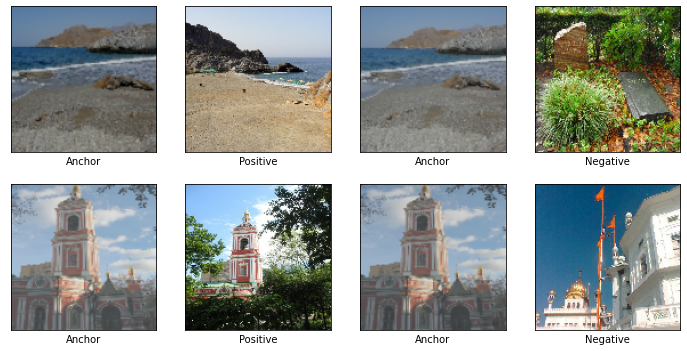

In [21]:
columns = 4
rows = 2
fig = plt.figure(figsize=(12, 6))
for i in np.arange(b_size):
  out = t[0][0][i]
  fig = plt.subplot(rows, columns, i * 2 + 1)
  fig.set_xticks([])
  fig.set_yticks([])
  plt.xlabel("Anchor")
  plt.imshow(out)
  out = t[0][1][i]
  fig = plt.subplot(rows, columns, i * 2 + 2)
  fig.set_xticks([])
  fig.set_yticks([])
  if t[1][i]:
    plt.xlabel("Positive")
  else:
    plt.xlabel("Negative")
  plt.imshow(out)
plt.show()

##Neural Network model

Defining Contrastive loss

In [22]:
def contrastive_loss(margin=1.0):
  def loss_fn(y_true, y_pred):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return (float(y_true) * margin_square + float(1 - y_true) * square_pred)

  return loss_fn


Defining DistanceLayer

In [23]:
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, anchor_embedding, validation_embedding):
        return tf.square(anchor_embedding - validation_embedding)

Function for building the Neural Network

In [39]:
def create_siamese_model(input_shape, loss_fn, accuracy, optimizer, fine_tuning=True):
  # Creating embedding model - ResNet152
  base_cnn = resnet.ResNet152(input_shape=input_shape, include_top=False, pooling='max')
  dense_features = Dense(128)
  # Enabling base model's parameters training
  if not fine_tuning:
    trainable = False
  else:
    trainable = True
  for layer in base_cnn.layers:
    if layer.name == "conv5_block2_out":
      trainable = True
    layer.trainable = trainable

  # Creating two different flows for anchor image and validation image
  # Anchor flow
  anchor_input = Input(name='anchor_input', shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
  anchor_embedded = base_cnn(anchor_input)
  anchor_output = dense_features(anchor_embedded)
  # Validation flow
  validation_input = Input(name='validation_input', shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
  validation_embedded = base_cnn(validation_input)
  validation_output = dense_features(validation_embedded)

  # Distance layer
  distances = DistanceLayer()(anchor_output, validation_output)
  classifier = Dense(1, activation='sigmoid')(distances)

  model = Model(inputs=[anchor_input, validation_input], outputs=classifier, name="SiameseModel")
  model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy])

  return model

In [42]:
siamese_model = create_siamese_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 
                                     loss_fn=contrastive_loss(1.0),
                                     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                                     accuracy=tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                                     fine_tuning=False)

In [43]:
siamese_model.summary()

Model: "SiameseModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_input (InputLayer)  [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet152 (Functional)         (None, 2048)         58370944    ['anchor_input[0][0]',           
                                                                  'validation_input[0][

###Training

In [27]:
now = datetime.now().strftime("%Y_%m_%d_t_%H_%M")
check_point_path = "{}/checkpoints/Siamese_Model_ResNet152_opt_Adam_s_{}_b{}_{}.h5".format(PATH, IMAGE_SIZE[0], BATCH_SIZE, now)
logs_path = "{}/logs/Siamese_Model_ResNet152_opt_Adam_s_{}_b{}_{}.h5".format(PATH, IMAGE_SIZE[0], BATCH_SIZE, now)

Defining space where to save trained model checkpoint

In [28]:
check_point = tf.keras.callbacks.ModelCheckpoint(
    filepath=check_point_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Defining path to save model training parameters

In [29]:
tb = TensorBoard(log_dir=logs_path)

In [ ]:
siamese_model.fit(DataGenerator(dataset=datas, labels=labels, b_labels=train_labels, size=IMAGE_SIZE, n_dup_couple=2, augment_data=True, batch_size=BATCH_SIZE), steps_per_epoch=len(train_labels)//(BATCH_SIZE//4),
                  validation_data=DataGenerator(dataset=datas, labels=labels, b_labels=validation_labels, size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False), validation_steps=len(validation_labels)//(BATCH_SIZE//2),
                  epochs=250,
                  callbacks=[tb, check_point])

### Test

Preparing test set for testing the Siamese Neural Network

In [ ]:
siamese_test_dataset = np.empty((0, 2))
siamese_test_labels = np.array([])
n_elements = 0
for path, label in zip(test_paths[:len(test_paths)//4], test_labels[:len(test_paths)//4]):
  if(label == 'nan'):
    # Taking false validation image
    siamese_test_dataset = np.append(siamese_test_dataset, [[path, np.random.choice(datas)]], axis=0)
    siamese_test_labels = np.append(siamese_test_labels, [0])
  else:
    # Taking positive validation image
    tmp = np.array([int(l) for l in label.split()])
    p_path = datas[np.isin(labels, tmp)]
    if len(p_path) > 1:
      siamese_test_dataset = np.append(siamese_test_dataset, [[path, np.random.choice(p_path)]], axis=0)
      siamese_test_labels = np.append(siamese_test_labels, [1])
  n_elements = n_elements + 1
  clear_output(True)
  print("Processed {} elements".format(n_elements))

Processed 29394 elements


Calculating predictions for each couple

In [ ]:
predictions = np.array([])
n_elements = 0
for path1, path2 in siamese_test_dataset:
  # Anchor img
  img1 = tf.io.read_file(path1)
  img1 = tf.io.decode_image(img1)
  img1 = tf.image.resize(img1, IMAGE_SIZE)
  # Validation img
  img2 = tf.io.read_file(path2)
  img2 = tf.io.decode_image(img2)
  img2 = tf.image.resize(img2, IMAGE_SIZE)

  pred = siamese_model.predict(((np.expand_dims(np.array(img1), axis=0), np.expand_dims(np.array(img2), axis=0))))[0]
  predictions = np.append(predictions, pred)
  n_elements = n_elements + 1
  clear_output(True)
  print("Processed {} elements".format(n_elements))

Processed 29137 elements


Precision

In [ ]:
precision = Precision(thresholds=0.5)
precision.update_state(siamese_test_labels, predictions)
precision.result().numpy()

0.008185349

Recall

In [ ]:
recall = Recall(thresholds=0.5)
recall.update_state(siamese_test_labels, predictions)
recall.result().numpy()

0.27962086

# **Save and load models**

## Save weights of trained model

Neural Network for non landmarks detection

In [ ]:
non_landmark_model.save_weights("{}/trainedModels/Non_Landmark_Model_ResNet50_opt_Adam_s_{}_b{}_{}.h5".format(PATH, IMAGE_SIZE[0], BATCH_SIZE, now))

Siamese Neural Network for pair images classification

In [ ]:
siamese_model.save_weights("{}/trainedModels/Siamese_Model_ResNet152_opt_Adam_s_{}_b{}_{}".format(PATH, IMAGE_SIZE[0], BATCH_SIZE, now))

## Load weights from file

Neural Network for non landmarks detection

In [ ]:
non_landmark_model.load_weights("{}/checkpoints/Non_Landmark_Model_ResNet50_opt_Adam_s_128_b32_2022_07_01_t_11_23.h5".format(PATH))

Siamese Neural Network for pair images classification

In [ ]:
siamese_model.load_weights("{}/checkpoints/Siamese_Model_ResNet152_opt_Adam_s_128_b32_2022_06_14_t_12_18.h5".format(PATH))

# **Retrieval top-100 neighbours using euclidean distance and ResNet152 not trained**

In [46]:
def generate_k_NN_classifier(train_images, train_labels):
  # Features
  model = resnet.ResNet152(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, pooling='max')
  train_dataset_tmp = np.empty((0, 2048))
  n_elements = 10
  # Generating features vector for ten images each iteration
  for i in np.arange(0, len(train_images) - n_elements, n_elements):
    images = np.empty((0, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    for path in test_paths[i:i+n_elements]:
      img = tf.io.read_file(path)
      img = tf.io.decode_image(img)
      img = tf.image.resize(img, IMAGE_SIZE)/255
      images = np.append(images, [img], axis=0)
    
    train_dataset_tmp = np.append(train_dataset_tmp, model.predict(images), axis=0)
  # Generating features vector for the last images
  if len(train_images) % 10 != 0:
    images = np.empty((0, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    for path in train_images[math.floor(len(train_images) / 10) * 10:]:
      img = tf.io.read_file(path)
      img = tf.io.decode_image(img)
      img = tf.image.resize(img, IMAGE_SIZE)/255
      images = np.append(images, [img], axis=0)
    train_dataset_tmp = np.append(train_dataset_tmp, model.predict(images), axis=0)

  # Creating KNN classifier
  k_NN_model = KNeighborsClassifier(n_neighbors=100)
  k_NN_model.fit(train_dataset_tmp, train_labels)

  # Returns the classifier model
  return k_NN_model

In [ ]:
k_NN_model = generate_k_NN_classifier(datas, labels)

Predicting labels on test set

In [ ]:
mod_resnet = resnet.ResNet152(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, pooling='max')
knn_features = np.empty((0, 2048))
counter = 0
for path in test_paths[:index_max]:
  img = tf.io.read_file(path)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, IMAGE_SIZE)/255
  f = mod_resnet.predict(np.expand_dims(img, axis=0))
  knn_features = np.append(knn_features, f, axis=0)
  clear_output(True)
  print("Processed {} elements".format(counter))
  counter = counter + 1

In [ ]:
distances, neighbors = k_NN_model.kneighbors(knn_features, n_neighbors=100)

In [ ]:
precision = Precision()
recall = Recall()

for y, i in zip(y_true, np.arange(len(y_true))):
  tmp_y = np.zeros(np.max(labels))
  tmp_y[y] = 1
  tmp_pred = np.zeros(np.max(labels))
  tmp_pred[neighbors[i]] = 1
  precision.update_state(tmp_y, tmp_pred)
  recall.update_state(tmp_y, tmp_pred)
  clear_output(wait=True)
  print("Processed {} elements".format(i+1))

Processed 29394 elements


Precision

In [ ]:
precision.result().numpy()

0.0

Recall

In [ ]:
recall.result().numpy()

0.0

# **K-NN Model**

In [ ]:
index_max = len(test_paths)//4

## Retrieval method

Features Generator class

In [ ]:
@attr.s(auto_attribs=True)
class FeaturesGenerator:
    """
    Args:
     dataset: numpy array of dataset images paths
     labels: numpy array of dataset images labels
     batch_size: size of generated batches
     model: neural network model for generating features
     size: tuple that defines input image resolution
     shuffle: whether to shuffle the questions around
    """
    dataset: np.ndarray
    labels: np.ndarray
    batch_size: int
    model: tf.keras.Model
    size: tuple=(128, 128)
    shuffle: bool=False
    _batch: iter=None

    def data_generator(self):
        num_samples = len(self.labels)
        
        while True:
            self.labels = shuffle(self.labels)

            # Iteration for each batch
            for offset in range(0, num_samples, self.batch_size):
                batch_images = self.dataset[offset:offset+self.batch_size]
                batch_labels = self.labels[offset:offset+self.batch_size]

                features = []
                y_train = []

                # Loading images
                for path, label in zip(batch_images, batch_labels):
                    img = tf.io.read_file(path)
                    img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
                    img = tf.image.resize(img, IMAGE_SIZE)
                    # Generating features vector
                    features.append(self.model.predict(np.expand_dims(img, axis=0))[0])
                    y_train.append(label)
                    
                
                yield features, y_train
                
                features, y_train = [], []

        return

    @property
    def batch(self):
        """The generator instance"""
        if self._batch is None:
            self._batch = self.data_generator()
        return self._batch

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.batch)

In [ ]:
featuresModel = Model(siamese_model.layers[0].input, siamese_model.layers[3].output)
featuresModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 anchor_input (InputLayer)   [(None, 128, 128, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense_1 (Dense)             (None, 128)               262272    
                                                                 
Total params: 58,633,216
Trainable params: 4,727,936
Non-trainable params: 53,905,280
_________________________________________________________________


### Saving test features

In [ ]:
for i, j in zip(np.arange(0, 1), np.arange(index_max, index_max+1)):
  print("Writing test_features-{}-{}".format(i, j-1))
  featuresGen = FeaturesGenerator(test_paths[i:j], test_labels[i:j], len(test_paths[i:j]), featuresModel)
  validation_features, knn_validation_labels = next(featuresGen)
  np.savetxt(PATH + "/features/test_features-{}-{}.csv".format(i, j-1), np.array(validation_features, dtype='float32'), delimiter=",")

Writing test_features-0-29393


###Loading Test set features

In [ ]:
validation_features = np.empty((0, 128), dtype='float32')
for i, j in zip(np.arange(0, 1), np.arange(index_max, index_max+1)):
  print("Reading test_features-{}-{}.csv".format(i, j-1))
  validation_features = np.append(validation_features, np.loadtxt(PATH + "/features/test_features-{}-{}.csv".format(i, j-1), delimiter=",", dtype='float32'), axis=0)

Reading test_features-0-29393.csv


### Saving Train set features

In [ ]:
featuresGen = FeaturesGenerator(datas, labels, len(datas), featuresModel)
train_features, knn_train_labels = next(featuresGen)
np.savetxt(PATH + "/features/train_features.csv", np.array(train_features, dtype='float32'), delimiter=",")

### Loading Train set features

In [ ]:
train_features = np.loadtxt(PATH + "/features/train_features.csv", delimiter=",", dtype='float32')

### Retrieving more similars images

Extrapolating ground truth from test labels string-based

In [ ]:
y_true = []

for e in test_labels[:index_max]:
  if e != 'nan':
    ids = e.split(' ')
    y_true.append([int(id) for id in ids])
  else:
    y_true.append([])

Extrapolating a Neural Network for similarity prediction from Siamese Neural Network

In [ ]:
def extract_classifier_model(siamese_model):
  anchor_input = Input(128)
  validation_input = Input(128)
  distance_layer = DistanceLayer()(anchor_input, validation_input)
  output = Model(siamese_model.layers[5].input, siamese_model.layers[5].output)(distance_layer)

  return Model(inputs=[anchor_input, validation_input], outputs=output)

In [ ]:
similarityModel = extract_classifier_model(siamese_model)

In [ ]:
@attr.s(auto_attribs=True)
class TestSetGenerator:
    """
    Args:
     test_features: generated features vectors on test set
     train_features: generated features vectors on training set
     batch_size: size of generated batches
    """
    test_features: np.ndarray
    train_features: np.ndarray
    batch_size: int
    _batch: iter=None

    def data_generator(self):
        num_samples = len(self.test_features)
        
        while True:

            # Iteration for each batch
            for offset in range(0, num_samples, self.batch_size):
                batch_features = self.test_features[offset:offset+self.batch_size]
                    
                features = (np.repeat(batch_features, len(self.train_features), axis=0), 
                            np.tile(self.train_features, (len(batch_features), 1)))

                yield features
                
                features = []

        return

    @property
    def batch(self):
        """The generator instance"""
        if self._batch is None:
            self._batch = self.data_generator()
        return self._batch

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.batch)

Function for getting top-n more similar images

In [ ]:
def getNMoreSimilarClasses(imgs, anchors_features, labels, similarityModel, n=10):
  dtype = [('similarity', 'float32'), ('label', int), ('index', int)]
  # Predicting similarities
  preds = similarityModel.predict(next(TestSetGenerator(imgs, anchors_features, len(imgs))), 
                                  batch_size=len(anchors_features), steps=len(imgs), 
                                  use_multiprocessing=True)
  results = np.array([(p, l, i) for p, l, i in zip(preds, np.tile(labels, len(imgs)), np.tile(np.arange(len(anchors_features)), len(imgs)))], dtype=dtype)
  # Returning only top-n more similar results (confidence, label, training images index)
  return np.array([np.sort(results[i:j], order='similarity')[::-1][:n] for i, j in 
          zip(np.arange(0, len(results)-len(anchors_features)+1, len(anchors_features)), 
              np.arange(len(anchors_features), len(results)+1, len(anchors_features)))])

#### Calculating 100 neirest neighbours with non-landmarks filtering

In [ ]:
n_elements = 10
n_top_q = 100
n_top = 100
results = np.empty((0, n_top), dtype=[('similarity', 'float32'), ('label', int), ('index', int)])

Predicting landmarks presences

In [ ]:
for i in np.arange(0, index_max - n_elements, n_elements):
  images = np.empty((0, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
  for path in test_paths[i:i+n_elements]:
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, IMAGE_SIZE)/255
    images = np.append(images, [img], axis=0)
  non_landmark_tmp = non_landmark_model.predict(images)
  clear_output(wait=True)
  print("Processed {} elements".format(i+n_elements))

Processed 29390 elements


Retrieving top-100 training images for only landmarks-presence labeled images

In [ ]:
for i in np.arange(0, index_max - n_elements, n_elements):
  if np.count_nonzero(non_landmark_tmp[i:i+n_elements] > 0.5) <= 0:
    results = np.append(results, np.zeros((n_elements, n_top), dtype=results.dtype), axis=0)
  else:
    features = validation_features[i:i+n_elements][np.where(non_landmark_tmp[i:i+n_elements] > 0.5)[0]]
    tmp = getNMoreSimilarClasses(features, np.array(train_features), labels, similarityModel, n=n_top_q)
    query_expansion = np.array([np.mean([train_features[i] for p, l, i in res], axis=0) for res in tmp])
    similar_classes = getNMoreSimilarClasses(query_expansion, np.array(train_features), labels, similarityModel, n=n_top)
    count = 0
    for j in np.arange(n_elements):
      if non_landmark_tmp[j] < 0.5:
        results = np.append(results, np.zeros((1, n_top), dtype=results.dtype), axis=0)
      else:
        results = np.append(results, np.array([similar_classes[count]]), axis=0)
        count = count + 1
  clear_output(wait=True)
  print("Processed {} elements".format(i+n_elements))

Processed 29390 elements


#### Calculating 100 neirest neighbours without non-landmarks filtering

In [ ]:
index_max = len(test_paths)//4

In [ ]:
n_elements = 10
n_top_q = 100
n_top = 100
results = np.empty((0, n_top), dtype=[('similarity', 'float32'), ('label', int), ('index', int)])
for i in np.arange(0, index_max - n_elements, n_elements):
  tmp = getNMoreSimilarClasses(validation_features[i:i+n_elements], np.array(train_features), labels, similarityModel, n=n_top_q)
  query_expansion = np.array([np.mean([train_features[i] for p, l, i in res], axis=0) for res in tmp])
  results = np.append(results, getNMoreSimilarClasses(query_expansion, np.array(train_features), labels, similarityModel, n=n_top), axis=0)
  clear_output(wait=True)
  print("Processed {} elements".format(i+n_elements))

Processed 29390 elements


#### Saving 100 Nearest Neighbours on file

In [ ]:
tmp = np.array([[(i, j) for i, j, k in row] for row in results], dtype='float32')
np.savetxt(PATH + "/features/test_top10-0-{}_QE_100.csv".format(index_max), np.reshape(tmp, (len(tmp), -1)), delimiter=",")

#### Loading 100 Nearest Neighbours from file

In [ ]:
top_similars = np.loadtxt(PATH + "/features/test_top10-0-29394_QE_100.csv", dtype='float32', delimiter=",")
top_similars = np.reshape(top_similars, (top_similars.shape[0], top_similars.shape[1]//2, 2))

In [ ]:
index_max = len(top_similars)

#### Calculating ground truth ranking positions

Calculating ground truth label ranking position with query expansion

In [ ]:
ranking = np.array([])
ranking_qe = np.array([])
counter = 0
for j in np.where([len(y) != 0 for y in y_true])[0]:
  tmp = getNMoreSimilarClasses([validation_features[j]], np.array(train_features), labels, similarityModel, n=len(train_features))
  ind = np.where(np.isin(tmp["label"], y_true[j])[0])[0]
  if len(ind) != 0:
    ranking = np.append(ranking, np.min(ind))
  # Applying query expansion
  query_expansion = np.array([np.mean([train_features[i] for p, l, i in res if p > 0.9], axis=0) for res in tmp])
  tmp = getNMoreSimilarClasses(query_expansion, np.array(train_features), labels, similarityModel, n=len(train_features))
  ind = np.where(np.isin(tmp["label"], y_true[j])[0])[0]
  if len(ind) != 0:
    ranking_qe = np.append(ranking_qe, np.min(ind))
  clear_output(wait=True)
  counter = counter + 1
  print("Processed {} elements".format(counter))

Processed 468 elements


Average ground truth label ranking position with query expansion

In [ ]:
np.round(np.mean(ranking_qe))

16994.0

Average ground truth label ranking position without query expansion

In [ ]:
np.round(np.mean(ranking))

15687.0

#### Calculating metrics

Taking only higher-confidence predictions

In [ ]:
dtype = [('index', int), ('label', int), ('confidence', 'float32')]
y_preditictions = np.array([], dtype=dtype)
for i in np.arange(len(top_similars)):
  y_preditictions = np.append(y_preditictions, np.array([(i, l, c) for c, l in top_similars[i] if c >= 0.9999], dtype=dtype))

GAP - Global Average Precision

In [ ]:
sommatory = 0
p_counter = 0

y_preditictions = np.sort(y_preditictions, order='confidence')

for i in np.arange(len(y_preditictions)):
  index = y_preditictions[i]["index"]
  if np.isin(y_preditictions[i]["index"], y_true[index]):
    p_counter = p_counter + 1
    sommatory = sommatory + p_counter/(i+1)

GAP = sommatory/np.count_nonzero(np.array([len(e) for e in y_true]) != 0)
print(GAP)

0.0


Precision and Recall

In [ ]:
y_true_onehot = np.empty((0, np.max(labels)))
for y in y_true:
  tmp = np.zeros((1, np.max(labels)))
  tmp[0][y] = 1
  y_true_onehot = np.append(y_true_onehot, tmp, axis=0)

In [ ]:
precision = Precision()
recall = Recall()

for y, i in zip(y_true, np.arange(len(y_true))):
  tmp_y = np.zeros(np.max(labels))
  tmp_y[y] = 1
  pred = y_preditictions[np.where(y_preditictions["index"]==i)]["label"]
  tmp_pred = np.zeros(np.max(labels))
  tmp_pred[pred] = 1
  precision.update_state(tmp_y, tmp_pred)
  recall.update_state(tmp_y, tmp_pred)
  clear_output(wait=True)
  print("Processed {} elements".format(i+1))

Processed 29380 elements


In [ ]:
print("Precision: {}".format(precision.result().numpy()))
print("Recall: {}".format(recall.result().numpy()))

Precision: 0.0
Recall: 0.0
